## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import json
import time
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, StandardScaler
# from sklearn.preprocessing import PowerTransform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.stats.stats import pearsonr, spearmanr

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats
from numpy import mean
from numpy import std
import math

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
print(tf.__version__)
# from tensorflow import keras

from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow import feature_column
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.regularizers import l1
from keras.constraints import unit_norm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import model_from_json
from collections import OrderedDict
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import mean_squared_error
from math import log
import category_encoders as ce
import tensorflow.keras.backend as K
print("GPU Available: ", tf.test.is_gpu_available())

import lime
import lime.lime_tabular

2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  False


## Helper Methods

In [2]:
output_column = 'LE_bowen_corr(mm)'
def read_data():
        file_path = "/Users/saraawad/Desktop/All_Manual_Daily_Albedo_NDVI_LST_Cleaned.csv"
        df = pd.read_csv(file_path, delimiter=',')

        columnsToDrop = ['Date', 'Year', 'Day', 'Site Id_1', 'Site Id_2', 'Site Id_3',
                        'Site Id_4', 'Site Id_5', 'Site Id_6','Vegetation', 'Latitude', 'Longitude',
                        'G','G-1','G-2','G-3','G-4','G-5',
                        'Climate_1', 'Climate_2', 'Climate_3',
                        'Latitude_1','Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5',
                        'Latitude_6','Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4',
                        'Longitude_5', 'Longitude_6',
                        'H', 'H_bowen_corr', 'H_bowen_corr-1', 'H_bowen_corr-2', 'H_bowen_corr-3', 'H_bowen_corr-4',
                        'H_bowen_corr-5', 'C_BOWENS',
                        'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
                        'LE', 'LE_bowen_corr',
                        'Elevation(m)_1','Elevation(m)_2', 'Elevation(m)_3', 'Elevation(m)_4',
                        'Elevation(m)_5', 'Elevation(m)_6',
                        'ETo', 'EToF', 'ETr', 'ETrF', 'ETo', 'SW_IN']

        df = df.drop(columnsToDrop, axis = 1)
        df.dropna(inplace=True)

        df = df[df[output_column].between(1, 15)]

        #Generate 5 lags
        lagsForColumns = ["SW_IN", "WS", "RH", "TA", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
        df = generate_lags(df, lagsForColumns)
        df.dropna(inplace=True)

        #Binary Encode Site Id
        df = binary_encode_column(df, "Site Id")

        #Drop columns
        df.drop(columns=['Site Id_0'], inplace=True)
        return df

def binary_encode_column(df, columnToEncode):
        encoder = ce.BinaryEncoder(cols=[columnToEncode])
        df_encoder = encoder.fit_transform(df[columnToEncode])
        df = pd.concat([df, df_encoder], axis=1)
        return df

def generate_lags_for(df, column, lags_count): 
            for i in range(lags_count):
                lag_name = column + "-" + str(i + 1)
                df[lag_name] = df[column].shift(i + 1)
            return df

def generate_lags(df, lagsForColumns):
        for k in range(len(lagsForColumns)):
            col = lagsForColumns[k]
            if col in df.columns:
                df = generate_lags_for(df, col, 5)
        return df
    
    
def split_train_test(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    
    unique_sites = df["Site Id"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site Id"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)
   
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, Y_train, X_test, Y_test

def get_accurate_prediction_score(y_test, y_pred):
    ratio = np.abs(y_test - y_pred) / y_test
    return ratio
           

## Data

In [3]:
df = read_data()
site_list = df['Site Id']
climate_list = df['Climate']
month_list = df['Month']

columns = ['Site Id', 'Climate', 'Month',
       'Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4','Site Id_5',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1', 'Vegetation_2',
       'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
       'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
       'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
       'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
       'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
       'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
       'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
       'EEflux Albedo-5', 'LE_bowen_corr(mm)']
df = df[columns]

df = df.sample(frac=1).reset_index(drop=True)

#split into train and test according to special split
X_train, Y_train, X_test, Y_test = split_train_test(df, 0.7, 0.3)

columnsToDrop = ['Site Id', 'Climate', 'Month']
X_train = X_train.drop(columnsToDrop, axis = 1)
X_test = X_test.drop(columnsToDrop, axis = 1)
print("columns", X_train.columns)


print(np.array(df['LE_bowen_corr(mm)']).mean())
n_input = X_train.shape[1]
print(n_input)

Number of sites: 26
columns Index(['Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4', 'Site Id_5',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'EEflux LST', 'EEflux LST-1',
       'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4', 'EEflux LST-5',
       'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
       'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo', 'EEflux Albedo-1',
       'EEflux Albedo-2', 'EEflux Albedo-3', 'EEflux Albedo-4',
       'EEflux Albedo-5'],
      dtype='object')
3.747154762527656
48


In [4]:
names = X_train.columns
categorical_features = ['Site Id_1', 'Site Id_2', 'Site Id_3', 'Site Id_4', 'Site Id_5',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3']

## Model Definition and Lime Analysis

Define our learner (Neural Network)

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model(first_neuron=30,
                 activation='relu',
                 init='uniform',
                 dropout_rate = 0.0,
                 dense_layer_sizes = 2,
                 optimizer='Adam',
                 loss='mse'):
    # Create model
    model = tf.keras.Sequential()
    model.add(Dense(first_neuron, input_dim=n_input, kernel_initializer=init, kernel_regularizer=l2(0.001), activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    for layer_size in range(dense_layer_sizes):
        model.add(Dense(first_neuron, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae', 'accuracy', 'mape'])
    return model

create_model().summary

param_grid = {
              'first_neuron':[64],
              'activation' : ['softmax'],
              'init': ['uniform'],
              'dropout_rate' : [0.4],
              'dense_layer_sizes' : [2],
              'optimizer' : ['Adam'],
              'loss': ['mean_squared_error'],
              'epochs':[300],
              'batch_size':[64]
             }



model = create_model()
history = model.fit(X_train,
                    Y_train,
                    epochs=300,
                   verbose=1,
                   callbacks=[])

Epoch 1/300
239/239 [==============================] - 0s 1ms/step - loss: 4.8462 - mse: 4.8444 - mae: 1.6210 - accuracy: 0.0000e+00 - mape: 49.8851
Epoch 2/300
239/239 [==============================] - 0s 992us/step - loss: 2.0087 - mse: 2.0050 - mae: 1.0606 - accuracy: 0.0000e+00 - mape: 35.8282
Epoch 3/300
239/239 [==============================] - 0s 949us/step - loss: 1.9081 - mse: 1.9037 - mae: 1.0247 - accuracy: 0.0000e+00 - mape: 34.3787
Epoch 4/300
239/239 [==============================] - 0s 1ms/step - loss: 1.8356 - mse: 1.8306 - mae: 1.0040 - accuracy: 0.0000e+00 - mape: 33.7371
Epoch 5/300
239/239 [==============================] - 0s 1ms/step - loss: 1.7981 - mse: 1.7926 - mae: 0.9910 - accuracy: 0.0000e+00 - mape: 33.4126
Epoch 6/300
239/239 [==============================] - 0s 1ms/step - loss: 1.7136 - mse: 1.7072 - mae: 0.9686 - accuracy: 0.0000e+00 - mape: 32.5034
Epoch 7/300
239/239 [==============================] - 0s 1ms/step - loss: 1.7349 - mse: 1.7278 - mae:

239/239 [==============================] - 0s 971us/step - loss: 1.4378 - mse: 1.4000 - mae: 0.8692 - accuracy: 0.0000e+00 - mape: 29.0593
Epoch 56/300
239/239 [==============================] - 0s 942us/step - loss: 1.5031 - mse: 1.4650 - mae: 0.8905 - accuracy: 0.0000e+00 - mape: 29.4587
Epoch 57/300
239/239 [==============================] - 0s 914us/step - loss: 1.4588 - mse: 1.4205 - mae: 0.8812 - accuracy: 0.0000e+00 - mape: 29.6583
Epoch 58/300
239/239 [==============================] - 0s 946us/step - loss: 1.4725 - mse: 1.4340 - mae: 0.8785 - accuracy: 0.0000e+00 - mape: 29.1161
Epoch 59/300
239/239 [==============================] - 0s 936us/step - loss: 1.4269 - mse: 1.3880 - mae: 0.8676 - accuracy: 0.0000e+00 - mape: 28.9116
Epoch 60/300
239/239 [==============================] - 0s 1ms/step - loss: 1.4369 - mse: 1.3978 - mae: 0.8636 - accuracy: 0.0000e+00 - mape: 28.5213
Epoch 61/300
239/239 [==============================] - 0s 986us/step - loss: 1.4323 - mse: 1.3931 - ma

239/239 [==============================] - 0s 964us/step - loss: 1.3751 - mse: 1.3265 - mae: 0.8491 - accuracy: 0.0000e+00 - mape: 28.1853
Epoch 110/300
239/239 [==============================] - 0s 941us/step - loss: 1.3704 - mse: 1.3218 - mae: 0.8462 - accuracy: 0.0000e+00 - mape: 28.1274
Epoch 111/300
239/239 [==============================] - 0s 891us/step - loss: 1.3593 - mse: 1.3109 - mae: 0.8411 - accuracy: 0.0000e+00 - mape: 28.0480
Epoch 112/300
239/239 [==============================] - 0s 905us/step - loss: 1.3309 - mse: 1.2825 - mae: 0.8356 - accuracy: 0.0000e+00 - mape: 27.8310
Epoch 113/300
239/239 [==============================] - 0s 904us/step - loss: 1.3548 - mse: 1.3064 - mae: 0.8443 - accuracy: 0.0000e+00 - mape: 28.1717
Epoch 114/300
239/239 [==============================] - 0s 932us/step - loss: 1.3722 - mse: 1.3239 - mae: 0.8481 - accuracy: 0.0000e+00 - mape: 28.3978
Epoch 115/300
239/239 [==============================] - 0s 921us/step - loss: 1.3307 - mse: 1.2

239/239 [==============================] - 0s 935us/step - loss: 1.2866 - mse: 1.2340 - mae: 0.8205 - accuracy: 0.0000e+00 - mape: 27.4735
Epoch 163/300
239/239 [==============================] - 0s 924us/step - loss: 1.2675 - mse: 1.2148 - mae: 0.8114 - accuracy: 0.0000e+00 - mape: 26.8938
Epoch 164/300
239/239 [==============================] - 0s 1ms/step - loss: 1.3071 - mse: 1.2544 - mae: 0.8319 - accuracy: 0.0000e+00 - mape: 27.8424
Epoch 165/300
239/239 [==============================] - 0s 1ms/step - loss: 1.3152 - mse: 1.2624 - mae: 0.8311 - accuracy: 0.0000e+00 - mape: 27.7912
Epoch 166/300
239/239 [==============================] - 0s 1ms/step - loss: 1.2934 - mse: 1.2401 - mae: 0.8260 - accuracy: 0.0000e+00 - mape: 27.5645
Epoch 167/300
239/239 [==============================] - 0s 910us/step - loss: 1.3049 - mse: 1.2515 - mae: 0.8252 - accuracy: 0.0000e+00 - mape: 27.4156
Epoch 168/300
239/239 [==============================] - 0s 902us/step - loss: 1.3352 - mse: 1.2817 - 

239/239 [==============================] - 0s 915us/step - loss: 1.3901 - mse: 1.3397 - mae: 0.8509 - accuracy: 0.0000e+00 - mape: 28.6462
Epoch 216/300
239/239 [==============================] - 0s 969us/step - loss: 1.3781 - mse: 1.3279 - mae: 0.8520 - accuracy: 0.0000e+00 - mape: 28.7029
Epoch 217/300
239/239 [==============================] - 0s 900us/step - loss: 1.3636 - mse: 1.3137 - mae: 0.8448 - accuracy: 0.0000e+00 - mape: 28.4881
Epoch 218/300
239/239 [==============================] - 0s 906us/step - loss: 1.3956 - mse: 1.3458 - mae: 0.8573 - accuracy: 0.0000e+00 - mape: 28.7092
Epoch 219/300
239/239 [==============================] - 0s 931us/step - loss: 1.3683 - mse: 1.3187 - mae: 0.8528 - accuracy: 0.0000e+00 - mape: 28.6110
Epoch 220/300
239/239 [==============================] - 0s 911us/step - loss: 1.3709 - mse: 1.3215 - mae: 0.8499 - accuracy: 0.0000e+00 - mape: 28.5054
Epoch 221/300
239/239 [==============================] - 0s 932us/step - loss: 1.4066 - mse: 1.3

239/239 [==============================] - 0s 853us/step - loss: 1.3030 - mse: 1.2519 - mae: 0.8316 - accuracy: 0.0000e+00 - mape: 27.9657
Epoch 269/300
239/239 [==============================] - 0s 857us/step - loss: 1.3345 - mse: 1.2833 - mae: 0.8336 - accuracy: 0.0000e+00 - mape: 27.8087
Epoch 270/300
239/239 [==============================] - 0s 837us/step - loss: 1.3155 - mse: 1.2643 - mae: 0.8303 - accuracy: 0.0000e+00 - mape: 27.8750
Epoch 271/300
239/239 [==============================] - 0s 971us/step - loss: 1.3039 - mse: 1.2528 - mae: 0.8232 - accuracy: 0.0000e+00 - mape: 27.6763
Epoch 272/300
239/239 [==============================] - 0s 1ms/step - loss: 1.3207 - mse: 1.2694 - mae: 0.8335 - accuracy: 0.0000e+00 - mape: 27.9204
Epoch 273/300
239/239 [==============================] - 0s 993us/step - loss: 1.3280 - mse: 1.2766 - mae: 0.8409 - accuracy: 0.0000e+00 - mape: 28.2252
Epoch 274/300
239/239 [==============================] - 0s 1ms/step - loss: 1.3360 - mse: 1.2845 

Define our LIME explainer

In [6]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                   feature_names=names,
                                                   class_names=[output_column],
                                                   categorical_features=categorical_features,
                                                   verbose=True,
                                                   mode='regression')


In [7]:
Y_predict = model.predict(X_test)

Get Accurate Points

In [8]:
#extract indices with error % not more than 10%
index_list = []
for i in range(len(Y_test)):
    score = get_accurate_prediction_score(np.array(Y_test)[i], np.array(Y_predict)[i])
    print(score)
    if score <= 0.1:
        index_list.append(i)
        
#subsetting dataset to get only the accurate predictions
X_test_accurate = X_test
X_test_accurate = X_test_accurate[X_test_accurate.index_list.isin(index)]

[0.13293715]
[0.22251879]
[0.51861306]
[0.31028064]
[0.10471021]
[0.45789344]
[0.05055196]
[0.2213346]
[1.17753357]
[0.17632943]
[0.04644884]
[0.17454516]
[0.43199219]
[0.18800321]
[0.61294398]
[0.24845461]
[0.82562543]
[0.1420889]
[0.3987924]
[0.21935563]
[0.06343602]
[0.39993278]
[0.39059998]
[1.2250358]
[0.07848546]
[0.04774552]
[1.07505159]
[0.00844732]
[0.33050457]
[0.15761962]
[1.14871959]
[0.29449061]
[0.0714428]
[0.96933627]
[1.0742306]
[0.50969121]
[0.21578546]
[0.49834815]
[0.85058364]
[0.22741061]
[0.31227076]
[0.24781925]
[1.17625202]
[0.02754387]
[1.22614311]
[0.20270073]
[0.31478909]
[0.34639121]
[0.59400421]
[0.07071426]
[1.08331541]
[0.46540494]
[0.33864987]
[0.89973479]
[0.61268324]
[0.09055494]
[0.58633341]
[0.10618359]
[0.08061143]
[0.28453208]
[0.46705809]
[0.19244402]
[0.1073645]
[0.39499237]
[0.79372064]
[0.32029629]
[0.64132009]
[0.16707685]
[2.05633273]
[0.26542973]
[0.03830799]
[0.3715793]
[0.16051695]
[0.45865609]
[0.37499159]
[0.09580372]
[0.85533239]
[0.0535

[0.15057755]
[0.10221077]
[1.12032702]
[0.06219426]
[0.03994557]
[0.05213747]
[1.33885371]
[0.12122995]
[0.45815057]
[0.45571894]
[0.0408757]
[0.13053497]
[0.12627231]
[0.24180141]
[0.79288494]
[0.7831359]
[0.17814843]
[0.54591816]
[0.32684714]
[0.17853456]
[2.07061385]
[0.94362153]
[0.57386413]
[0.81893238]
[0.34207309]
[0.16531354]
[0.24435749]
[0.17306055]
[0.22985791]
[0.14329393]
[0.63427594]
[0.14904234]
[0.43466218]
[0.85883122]
[0.30084983]
[0.41337605]
[0.29716861]
[0.12744954]
[0.10682455]
[0.17472033]
[0.2125305]
[0.8468975]
[0.52326589]
[0.22177838]
[0.03293091]
[0.26086133]
[0.17101059]
[0.21881005]
[1.82864199]
[0.49880032]
[0.08842363]
[0.11639278]
[0.40877634]
[0.14674072]
[0.32172684]
[2.35459071]
[0.23908165]
[0.5140006]
[0.79154428]
[0.91099645]
[0.15449441]
[0.06216824]
[0.44211234]
[0.43308119]
[1.47221012]
[0.0551727]
[0.00765276]
[2.02676929]
[0.65642661]
[0.1446781]
[0.47578551]
[0.79491159]
[0.52418424]
[0.24889561]
[0.73222091]
[2.74899847]
[0.21322078]
[3.436

[0.62822499]
[0.21242127]
[0.04046549]
[0.77195662]
[0.11881732]
[0.14716809]
[0.30741109]
[0.07489646]
[1.60339394]
[0.05291847]
[1.14146751]
[0.09047821]
[2.08707611]
[0.10219994]
[1.59594013]
[0.33620175]
[0.55828508]
[0.14657293]
[1.64694338]
[0.32138997]
[0.38782652]
[0.38289192]
[2.11707989]
[1.86900637]
[0.10366952]
[0.4889523]
[0.22619296]
[0.55652518]
[0.77967622]
[0.61289186]
[0.2500331]
[0.82022247]
[1.51509179]
[0.45894643]
[0.83858829]
[0.03178438]
[0.66320662]
[0.85787129]
[0.11176716]
[0.01969676]
[0.6934105]
[0.14552208]
[0.02030138]
[0.20666009]
[0.23230701]
[0.02481416]
[0.06147186]
[0.34606397]
[1.19599357]
[0.27204102]
[0.18425009]
[0.03265695]
[2.0820923]
[2.2026477]
[0.03823012]
[0.37562409]
[2.17926376]
[0.39226429]
[1.476933]
[0.00802158]
[0.41883441]
[0.07404445]
[0.00622521]
[0.6809084]
[0.23508695]
[0.8632702]
[0.41165447]
[2.10517781]
[0.24575227]
[0.27662829]
[2.26402458]
[0.06438985]
[0.15665205]
[0.45574916]
[0.26839621]
[0.27218656]
[1.52759371]
[0.77411

[0.43127889]
[0.23760836]
[0.26194373]
[0.42093019]
[0.02626302]
[0.05149728]
[0.06029675]
[0.18171989]
[0.06238875]
[0.23358341]
[0.71102188]
[0.06697302]
[0.86677238]
[0.41496124]
[0.08463381]
[0.13992397]
[0.05742548]
[0.24998442]
[1.03352134]
[0.23424364]
[0.42221788]
[0.90776504]
[0.13568057]
[0.49541795]
[0.31659023]
[0.13961288]
[0.26762648]
[0.01148953]
[0.06180001]
[0.06698519]
[0.31096703]
[0.15690079]
[0.1710138]
[0.0438749]
[0.08806776]
[0.28997651]
[0.29573493]
[0.06013822]
[0.80022903]
[0.17439701]
[0.84317517]
[1.05908026]
[0.04530979]
[1.53841816]
[0.25015448]
[0.24266392]
[0.25227094]
[0.31463957]
[0.11519316]
[1.81318254]
[0.16787798]
[0.17700227]
[0.05081664]
[0.40496189]
[0.23467575]
[0.19381323]
[1.87191766]
[0.13568326]
[0.31903365]
[0.69623472]
[0.21280153]
[2.18024279]
[0.34800625]
[0.31976919]
[0.47965531]
[0.12297597]
[1.47905925]
[1.02837989]
[0.83116104]
[2.66615947]
[1.67196017]
[0.27976764]
[0.33094606]
[0.92002056]
[0.60843842]
[0.6769988]
[1.76180212]
[1

AttributeError: 'DataFrame' object has no attribute 'index_list'

Interpret the first record

Intercept 3.367528538938043
Prediction_local [4.89890669]
Right: 13.4108925


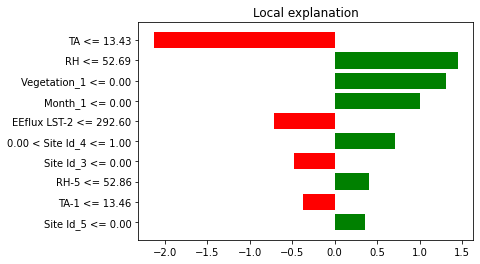

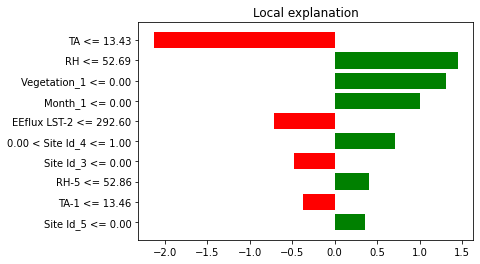

In [9]:
exp = explainer.explain_instance(np.array(X_test_scaled)[0], 
     model.predict, num_features=10)
exp.as_pyplot_figure()

Interpret a random record

In [16]:
i = 19
exp = explainer.explain_instance(np.array(X_test)[i].astype(int), model.predict, num_features=10)

Intercept 3.9924542274562422
Prediction_local [2.74736862]
Right: 1.6885083


In [17]:
exp.show_in_notebook(show_table=True, show_all=False)

In [33]:
exp.as_list()

[('0.00 < Month_1 <= 1.00', -0.7535069132026405),
 ('Vegetation_1 > 0.00', -0.6394876833738881),
 ('Site Id_4 <= 0.00', -0.41278394006058095),
 ('Site Id_1 <= 0.00', -0.381731467848226),
 ('Vegetation_2 <= 0.00', -0.30166577434583514),
 ('EEflux NDVI <= 0.44', -0.25348973704420646),
 ('0.00 < Site Id_5 <= 1.00', -0.24690120126836648),
 ('62.76 < RH <= 71.47', -0.24443819154706262),
 ('18.79 < TA <= 23.07', 0.22704398862158726),
 ('Month_2 <= 0.00', -0.1808670056378569)]

interpret an accurate random record

In [34]:
i = 20
exp = explainer.explain_instance(np.array(X_test_accurate)[i].astype(int), model.predict, num_features=10)

Intercept 3.169354229536087
Prediction_local [2.00660234]
Right: 1.0479251


In [35]:
exp.show_in_notebook(show_table=True, show_all=False)